In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
%load_ext cudf.pandas
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Setting Matplotlib defaults
plt.style.use('seaborn-v0_8')
plt.rc('figure', figsize=(8,5), dpi=150)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=15, titlepad=10)
plt.rc('animation', html='html5')
plt.tight_layout()
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings
warnings.simplefilter('ignore')

pd.set_option('display.max_columns', 500)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e5/sample_submission.csv
/kaggle/input/playground-series-s5e5/train.csv
/kaggle/input/playground-series-s5e5/test.csv


<Figure size 1200x750 with 0 Axes>

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s5e5/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s5e5/test.csv', index_col='id')

# Data Understanding

In [3]:
test.shape

(250000, 7)

In [4]:
train.head(10)

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
id,,,,,,,,
0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,female,38,166.0,61.0,25.0,102.0,40.6,146.0
5,female,26,156.0,56.0,19.0,100.0,40.5,103.0
6,female,21,172.0,73.0,3.0,81.0,38.3,9.0
7,male,46,188.0,94.0,23.0,100.0,40.8,145.0
8,female,33,166.0,63.0,25.0,107.0,40.5,161.0


In [5]:
train.describe()

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,41.420404,174.697685,75.145668,15.421015,95.483995,40.036253,88.282781
std,15.175049,12.824496,13.982704,8.354095,9.449845,0.779875,62.395349
min,20.000000,126.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,34.000000
50%,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,77.000000
75%,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,136.000000
max,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


In [6]:
train.isnull().sum()

Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

In [7]:
train.info()

<class 'cudf.core.dataframe.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   Sex         750000 non-null  object
 1   Age         750000 non-null  int64
 2   Height      750000 non-null  float64
 3   Weight      750000 non-null  float64
 4   Duration    750000 non-null  float64
 5   Heart_Rate  750000 non-null  float64
 6   Body_Temp   750000 non-null  float64
 7   Calories    750000 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 52.2+ MB


# Data Preprocessing

## Reducing memory usage

In [8]:
train['Sex'] = train['Sex'].astype('category')
test['Sex'] = test['Sex'].astype('category')

In [9]:
train['Age'] = train['Age'].astype('int8')
test['Age'] = test['Age'].astype('int8')

In [10]:
num_cols = test.select_dtypes(include='float64').columns
for col in num_cols:
    train[num_cols] = train[num_cols].astype('float32')
    test[num_cols] = test[num_cols].astype('float32')

In [11]:
train.info()

<class 'cudf.core.dataframe.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   Sex         750000 non-null  category
 1   Age         750000 non-null  int8
 2   Height      750000 non-null  float32
 3   Weight      750000 non-null  float32
 4   Duration    750000 non-null  float32
 5   Heart_Rate  750000 non-null  float32
 6   Body_Temp   750000 non-null  float32
 7   Calories    750000 non-null  float64
dtypes: category(1), float32(5), float64(1), int8(1)
memory usage: 27.2 MB


In [12]:
from sklearn.preprocessing import KBinsDiscretizer

kmeans = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='kmeans')
train['age_bins'] = kmeans.fit_transform(train[['Age']])
test['age_bins'] = kmeans.transform(test[['Age']])

In [13]:
from sklearn.preprocessing import KBinsDiscretizer

kmeans = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='uniform')
train['weight_bins'] = kmeans.fit_transform(train[['Weight']])
test['weight_bins'] = kmeans.transform(test[['Weight']])

# Feature Understanding via Data Visualization

Yeo-Johnson transformation of target variable gives more normal distribution than log-transformation.

Text(0.5, 1.0, 'Calories Distribution')

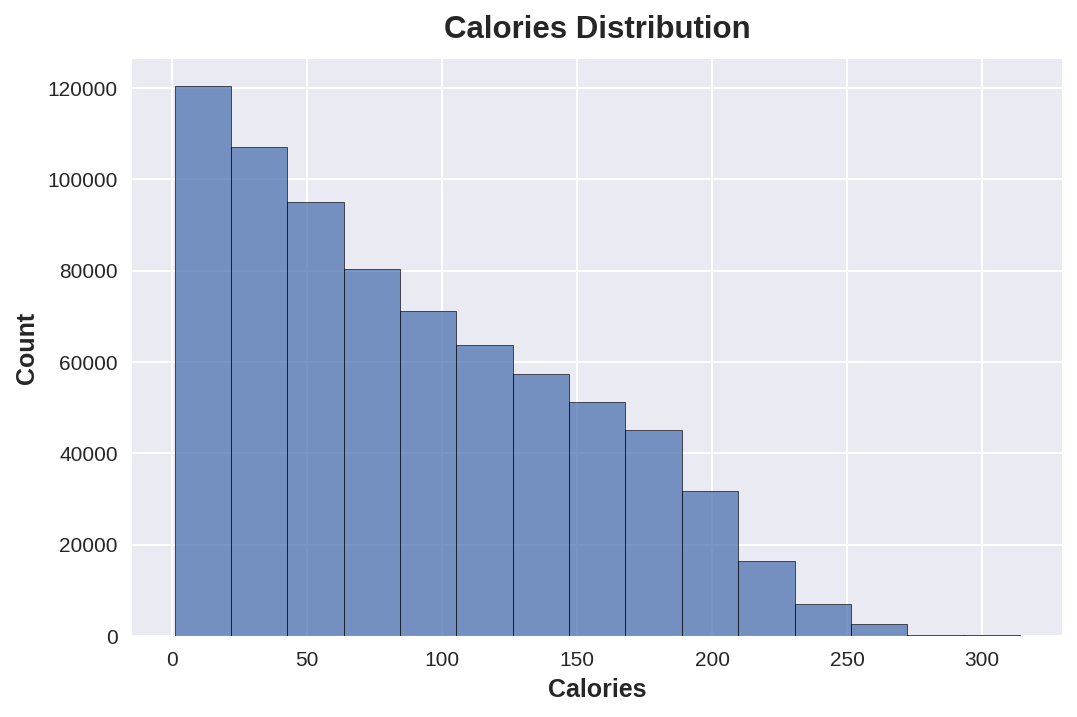

In [14]:
sns.histplot(x='Calories', bins=15, data=train, cbar=True)
plt.title("Calories Distribution")

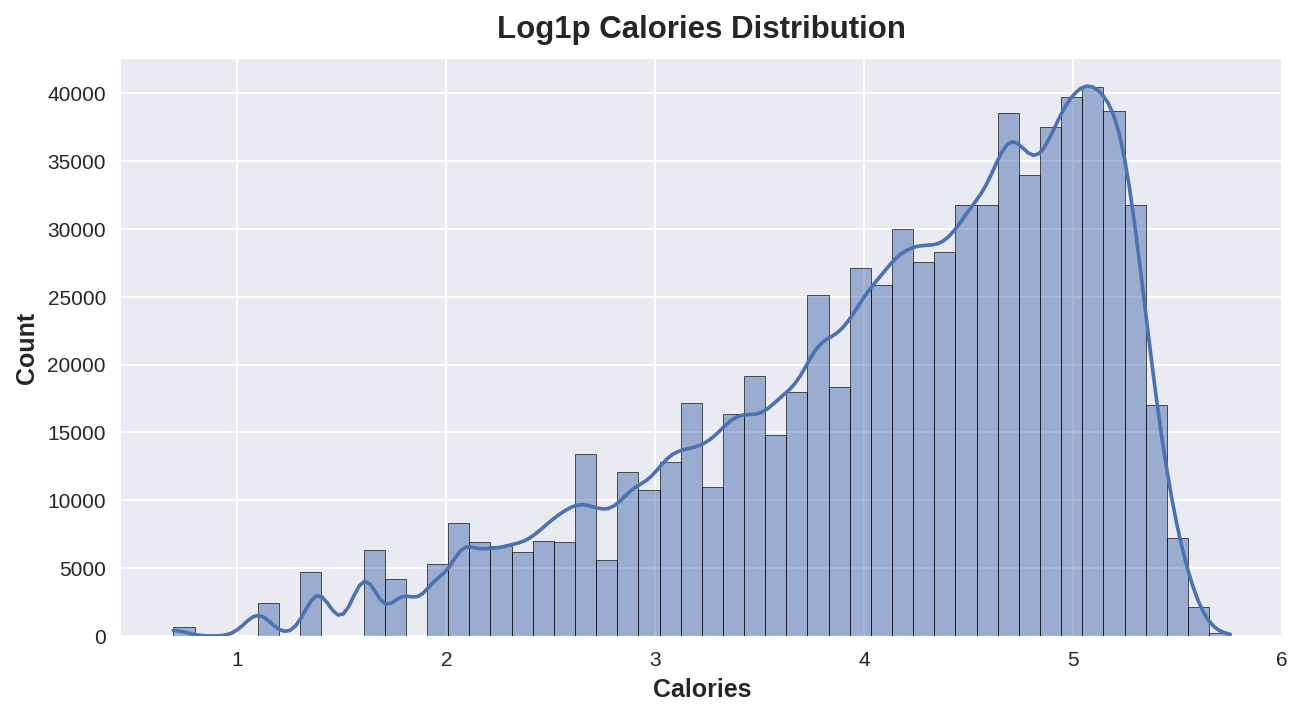

In [15]:
plt.figure(figsize=(10, 5))
sns.histplot(np.log1p(train["Calories"]), bins=50, kde=True)
plt.title("Log1p Calories Distribution")
plt.show()

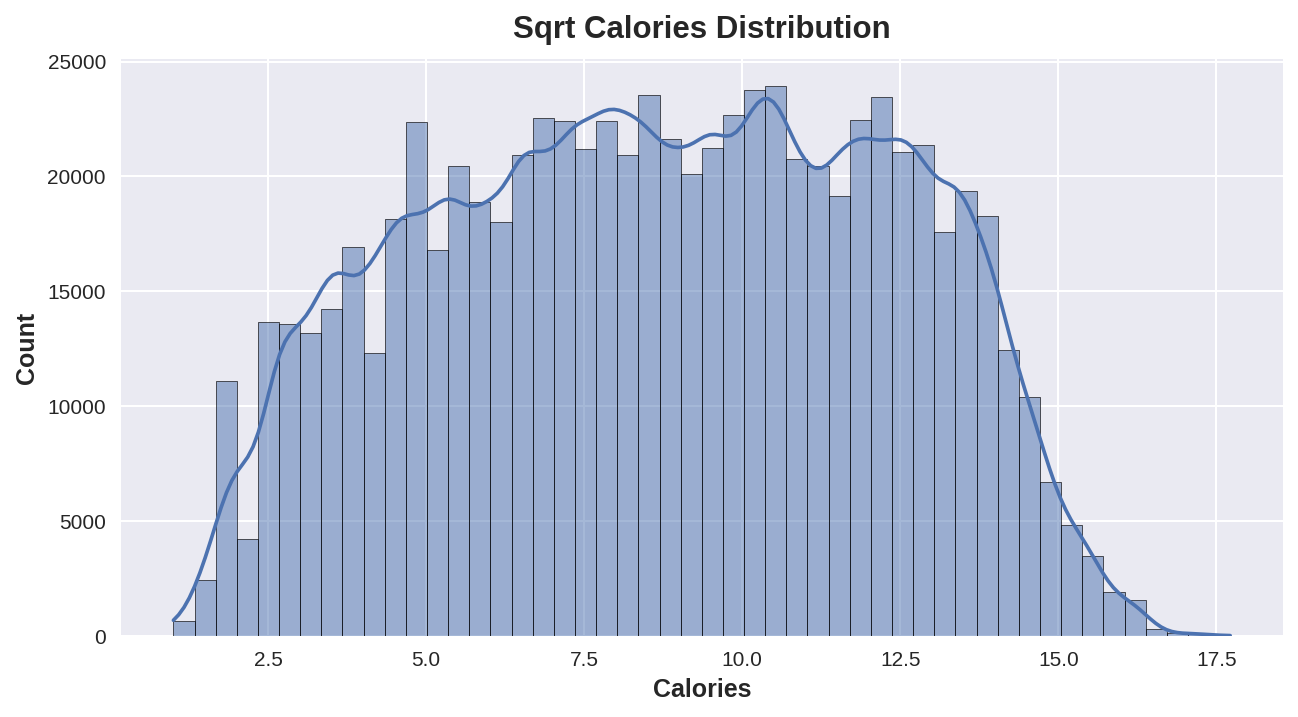

In [16]:
plt.figure(figsize=(10, 5))
sns.histplot(np.sqrt(train["Calories"]), bins=50, kde=True)
plt.title("Sqrt Calories Distribution")
plt.show()

In [17]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train['Sex'] = le.fit_transform(train['Sex']).astype('int8')
test['Sex'] = le.transform(test['Sex']).astype('int8')

In [18]:
features = ['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']

In [19]:
def add_features(df):
    for i, c1 in enumerate(features):
        for c2 in (features[i+1:]):
            m = f'{c1}*{c2}'
            df[m] = df[c1] * df[c2]
    return df

In [20]:
def feature_transform(df):
    df['duration_expo'] = df['Duration'] ** 2
    df['duration_log'] = np.log1p(df['Duration'])

    df['heart_expo'] = df['Heart_Rate'] ** 2
    df['heart_log'] = np.log1p(df['Heart_Rate'])
    
    df['weight_log'] = np.log1p(df['Weight'])

    df['body_expo'] = df['Body_Temp'] ** 2
    df['body_log'] = np.log1p(df['Body_Temp'] ** 2)


    df['BMI'] = df['Weight'] / ((df['Height']/100) ** 2)
    df['BMI_duration'] = df['BMI'] / df['Duration']
    
    return df

In [21]:
X = train.copy()
y = X.pop('Calories')
y = np.sqrt(y)

X = add_features(X)
X = feature_transform(X)

X_test = test.copy()
X_test = add_features(X_test)
X_test = feature_transform(X_test)

In [22]:
from sklearn.model_selection import cross_val_score
import optuna
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
from xgboost import XGBRegressor

n_folds = 7
kf = KFold(n_splits=n_folds, shuffle=True, random_state=100)

oof_xgb = np.zeros(len(y))
oof_test = np.zeros(len(X_test))

for fold, (train_index, valid_index) in enumerate(kf.split(X, y), start=1):
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
    
        xgb = XGBRegressor(
            n_estimators=900, 
            learning_rate=0.05, 
            max_depth=8, 
            min_child_weight=1, 
            reg_alpha=0.01722769, 
            reg_lambda=0.1988406256, 
            subsample=0.687651847, 
            colsample_bytree=0.991963, 
            gamma=0.3676562,
            early_stopping_rounds=50, 
            random_state=100
        ).fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)
    
        xgb_pred = xgb.predict(X_valid)
        oof_xgb[valid_index] = xgb_pred
        fold_rmsle = np.sqrt(mean_squared_log_error(np.square(y_valid), np.square(xgb_pred)))
        print(f"Fold {fold} RMSE: {fold_rmsle:.6f}")

overall_rmsle = np.sqrt(mean_squared_log_error(np.square(y), np.square(oof_xgb)))
print(f"\nOverall OOF RMSLE: {overall_rmsle:.6f}")    

Fold 1 RMSE: 0.059825
Fold 2 RMSE: 0.061839
Fold 3 RMSE: 0.060227
Fold 4 RMSE: 0.058759
Fold 5 RMSE: 0.061384
Fold 6 RMSE: 0.059866
Fold 7 RMSE: 0.060563

Overall OOF RMSLE: 0.060359


In [23]:
test_xgb = xgb.predict(X_test)
test_xgb  = np.square(test_xgb)
#y_preds = np.clip(test_xgb, 1, 314)

sub = pd.read_csv('/kaggle/input/playground-series-s5e5/sample_submission.csv')
sub['Calories'] = test_xgb
sub.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")
print(sub.head(20))

Your submission was successfully saved!
        id    Calories
0   750000   28.104450
1   750001  108.365913
2   750002   87.428574
3   750003  125.284058
4   750004   75.570068
5   750005   21.949841
6   750006   48.044979
7   750007    6.831782
8   750008    9.854651
9   750009  205.243744
10  750010   77.878334
11  750011  216.847748
12  750012   71.472786
13  750013  251.242188
14  750014   87.680374
15  750015  137.404678
16  750016   66.669266
17  750017  161.176239
18  750018  125.395782
19  750019  190.002319
